# Figure S2

This performs a sensitivity analysis on t, the time to progression.

In [64]:
import os
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import to_rgb


sys.path.append("../utils")
from myUtils import convert_ode_parameters, obtain_architecture

In [65]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

In [66]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

def redistribute_rgb(col):
    r, g, b = col
    threshold = 1 
    m = max(r, g, b)
    if m <= threshold:
        return r, g, b
    total = r + g + b
    if total >= 3 * threshold:
        return threshold, threshold, threshold
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return (gray + x * r), (gray + x * g), (gray + x * b)

/tmp/ipykernel_11916/2990576886.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([''] + list(colors.keys()));


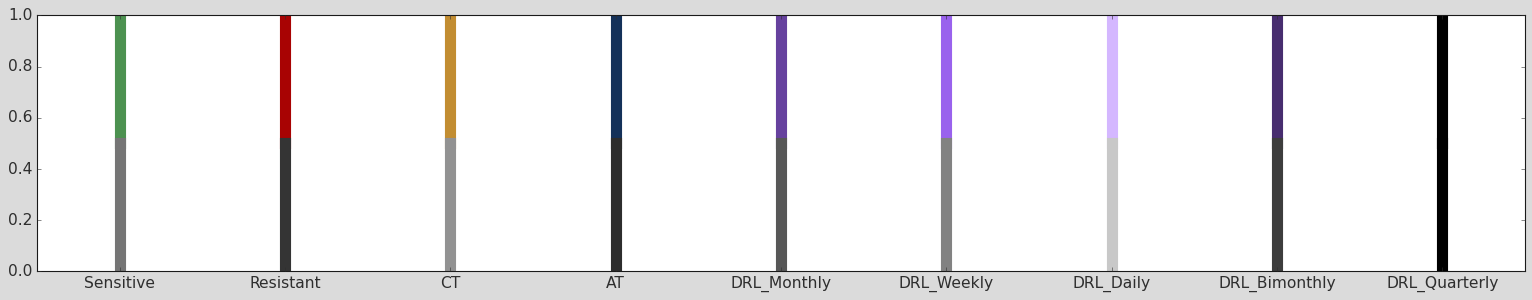

In [67]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

colors['DRL_Weekly'] = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Daily'] = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL_Monthly'])]))

colors['DRL_Bimonthly'] = redistribute_rgb(tuple([0.7 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Quarterly'] = redistribute_rgb(tuple([0 * x for x in to_rgb(colors['DRL_Monthly'])]))

fig, ax = plt.subplots(1, 1, figsize=(24, 4))
for i, col in enumerate(colors.values()):
    plt.axvline(i+1, 0.5, 1, color = col, linewidth=10)
    plt.axvline(i+1, 0, 0.5, color = convert_to_rgb_grayscale(col), linewidth=10)
plt.xlim(0.5, len(colors.values()) + 0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().set_xticklabels([''] + list(colors.keys()));

## Section A - Variation with treatment interval $\tau$

In [68]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "tau_sens")
runFromScratch = True

models = {
    'test_currSizeOnly_p25_step1': 100000,
    'test_currSizeOnly_bruchovsky_group_monthly': 150000,
    'test_currSizeOnly_step2_synth_group': 180000}
n_replicates = 10

labels = ['Patient 25', 'Bruchovsky\nGroup', 'Synthetic\nGroup']
group_cols = ['b', 'g', 'r']

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['K'] = odeParamDic['k']

In [7]:
trainingDataDf = pd.read_csv("../models/trainingPatientsDf_bruchovsky.csv", index_col=0)
eval_df = trainingDataDf.rename(columns={'fR':'rFrac'}).apply(lambda row: pd.Series(convert_ode_parameters(**row)), axis=1)
eval_df['PatientId'] = trainingDataDf.apply(lambda row: int(trainingDataDf.loc[row.name]['PatientId']), axis=1)

In [8]:
odeParamDic = eval_df[eval_df.PatientId == 25].iloc[0].to_dict()
odeParamDic['K'] = odeParamDic['k']

In [9]:
print(odeParamDic)

{'n0': 0.4256746072629833, 'rS': 0.027, 'rR': 0.02079279901058913, 'dS': 0.00786821675560546, 'dR': 0.00786821675560546, 'dD': 1.5, 'k': 1.0, 'D': 0.0, 'theta': 1.0, 'DMax': 1.0, 'S0': 0.42567035051691066, 'R0': 4.256746072629835e-06, 'PatientId': 25.0, 'K': 1.0}


In [40]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

updating_intervals = [int(x) for x in np.linspace(7, 200, 50)]
odeParamDic['sigma'] = 0

for model_name, n_epochs in models.items():
    for updating_interval in updating_intervals:
        currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
        results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
        argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':0}]).to_dict(),
                'architecture_kws':obtain_architecture(model_name),
                'n_replicates':n_replicates, 'updating_interval':updating_interval,
                'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
                'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
        # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
        # to run it I made a separate environment. Use an external script to run the evaluation in that
        # environment.
        if runFromScratch:
            param_dir = os.path.join(file_path, "data", "Fig3", "params", "params_pCR_%s_%s.json"%(n_epochs, updating_interval))
            with open(param_dir, "w") as outfile:
                json.dump(argDic, outfile)
            command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_%s_%s.json"%(n_epochs, updating_interval)
            # p = subprocess.run(command, capture_output=True, shell=True)
            print(command)

            # Load results and process them
            dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
            # Extract TTP information
            tmpList = []
            for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
                ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
                tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
            ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
            ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
        else:
            # Load results
            dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
            ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)
                
        # For these historical models (daily and weekly), we need to adapt evaluation code so that normalisation is not used. This is L473 of drlUtils.py (in run_evaluation())
        # We also change ODE evaluation interval (removing argument in L427) so info with the same interval is fed in)

/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_7.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_10.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_14.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_18.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_22.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_26.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_30.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_eva

In [41]:
def generate_stats(final_states):
    stats_df = final_states.groupby(['PatientId'])['Time'].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats_df.index:
        m, c, s = stats_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))  # For 95% confidence interval
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

    stats_df['ci95_hi'] = ci95_hi
    stats_df['ci95_lo'] = ci95_lo
    return stats_df

In [42]:
means = []; upper = []; lower = []  # Going to fill with nested lists

for m, (model_name, n_epochs) in enumerate(models.items()):
    means.append([]); upper.append([]); lower.append([])
    for updating_interval in updating_intervals:
        results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%s.csv'%(model_name,n_epochs, updating_interval)

        time_df = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
            
        final_time_df = time_df.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
        stats_df = generate_stats(final_time_df)
        means[m].append(stats_df['mean'].values[0]); upper[m].append(stats_df['ci95_hi'].values[0]); lower[m].append(stats_df['ci95_lo'].values[0])

In [13]:
print(means)
print(upper)
print(lower)

[[2342.55, 2316.0, 2284.1, 2251.8, 2222.0, 2204.8, 2184.0, 2162.4, 2122.3, 1050.0, 276.0, 300.0, 324.0, 348.0, 186.0, 198.0, 210.0, 219.0, 231.0, 243.0, 255.0, 267.0, 279.0, 291.0, 303.0, 315.0, 327.0, 339.0, 351.0, 363.0, 375.0, 387.0, 399.0, 408.0, 420.0, 432.0, 444.0, 456.0, 468.0, 480.0, 492.0, 504.0, 516.0, 528.0, 540.0, 552.0, 564.0, 576.0, 588.0, 600.0], [1528.45, 1528.0, 1522.5, 1521.0, 1524.6, 1517.1, 1528.5, 1499.4, 1520.0, 1545.6, 1515.7, 1500.0, 1509.3, 1499.3, 1488.0, 1452.0, 1470.0, 1533.0, 1540.0, 1539.0, 1530.0, 1513.0, 1488.0, 485.0, 505.0, 525.0, 545.0, 565.0, 585.0, 605.0, 625.0, 645.0, 665.0, 680.0, 700.0, 720.0, 740.0, 760.0, 780.0, 800.0, 820.0, 840.0, 860.0, 880.0, 900.0, 920.0, 940.0, 960.0, 980.0, 1000.0], [1702.75, 1694.0, 1680.7, 1679.4, 1672.0, 1709.5, 1678.5, 1666.0, 1666.3, 1677.9, 1697.4, 1662.5, 1674.0, 1670.4, 1612.0, 1584.0, 1610.0, 1606.0, 1174.25, 1490.4, 850.0, 890.0, 930.0, 485.0, 505.0, 504.0, 523.2, 485.9, 444.6, 423.5, 425.0, 399.9, 412.3, 421.6

In [49]:
means = [923.3, 935.5, 951.3, 967.5, 1004.3, 1021.8, 1039.5, 1043.8, 1067.8, 1054.2, 1087.9, 990.0, 966.6, 867.1, 682.0, 726.0, 556.5, 580.35, 608.3, 178.2, 204.0, 231.4, 241.8, 310.4, 383.8, 446.25, 495.95, 452.0, 468.0, 484.0, 500.0, 516.0, 532.0, 544.0, 560.0, 576.0, 592.0, 456.0, 468.0, 480.0, 492.0, 504.0, 516.0, 528.0, 540.0, 552.0, 564.0, 576.0, 588.0, 600.0]
upper = [926.5861740351774, 938.5079858622288, 955.95799875709, 975.9404656893225, 1012.7375906264139, 1032.9525278135309, 1053.1738698176293, 1053.589265700111, 1086.439589695055, 1059.8656509636673, 1107.8202168451526, 1023.0427474326021, 1036.088827145846, 872.784, 682.0, 726.0, 563.36, 587.504, 623.3919999999999, 209.952, 249.8647935154027, 288.5589656567311, 291.9814799639112, 374.5029300192482, 450.5463498138564, 507.58247079389685, 548.4527577801996, 452.0, 468.0, 484.0, 500.0, 516.0, 532.0, 544.0, 560.0, 576.0, 592.0, 456.0, 468.0, 480.0, 492.0, 504.0, 516.0, 528.0, 540.0, 552.0, 564.0, 576.0, 588.0, 600.0]
lower = [920.0138259648226, 932.4920141377712, 946.6420012429099, 959.0595343106775, 995.862409373586, 1010.6474721864691, 1025.8261301823707, 1034.010734299889, 1049.160410304945, 1048.5343490363327, 1067.9797831548476, 956.9572525673979, 897.111172854154, 861.416, 682.0, 726.0, 549.64, 573.196, 593.208, 146.44799999999998, 158.1352064845973, 174.2410343432689, 191.61852003608882, 246.2970699807518, 317.0536501861436, 384.91752920610315, 443.44724221980033, 452.0, 468.0, 484.0, 500.0, 516.0, 532.0, 544.0, 560.0, 576.0, 592.0, 456.0, 468.0, 480.0, 492.0, 504.0, 516.0, 528.0, 540.0, 552.0, 564.0, 576.0, 588.0, 600.0]

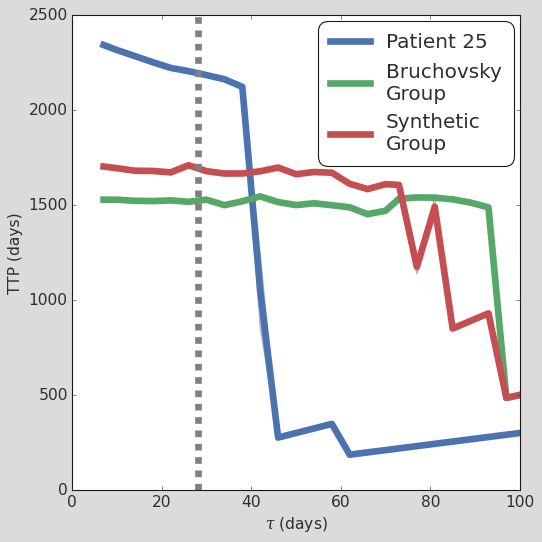

In [71]:
# Plot variation in ttp
fix, ax = plt.subplots(1,1,figsize=(7,7))
for m, (model_name, n_epochs) in enumerate(models.items()):
    ax.plot(updating_intervals, means[m], linestyle = '-', linewidth='6', color=group_cols[m], label=labels[m])
    ax.fill_between(updating_intervals, lower[m], upper[m], color=group_cols[m], alpha=0.4)
# ax.set_ylim(-0.01,1.03); ax.set_xlim(0.0, 1.2);
ax.vlines(ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], x=28, linestyles="--", linewidth=6, color='gray')

# plt.plot([0, 200], [0, 400], linestyle=':', linewidth=6, color='gray')  # At long t - maps onto 2tau (one treatment, one holiday)

plt.legend(loc=1, fontsize=18, numpoints=1, markerscale=2).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel(r'$\tau$ (days)'); plt.ylabel('TTP (days)'); plt.xlim(0, 100)
plt.tight_layout(); plt.savefig("figures/fig_tau_sensitivity.png")

In [15]:
# Get the index of the value of a list closest to 28
loss = 0.2

idx = (np.abs([int - 28 for int in updating_intervals])).argmin()
print(f"Series index for training interval: {updating_intervals[idx]}")
print_labels = [s.replace('\n', ' ') for s in labels]

for m, (model_name, n_epochs) in enumerate(models.items()):
    later_list = means[m][idx:]
    later_list = [x for x in later_list if x > means[m][0] * (1-loss)]
    print(f"{print_labels[m]} has {int(loss*100)}% loss of performance at interval {updating_intervals[len(later_list) + idx]} days")
    # Find the first value in means that is 20% lower than the value at idx
    filtered_values = [x for x in means[m] if x > means[m][0] * (1-loss)]
    print(f"{print_labels[m]} has {int(loss*100)}% loss of performance at crude interval {updating_intervals[len(filtered_values)]} days")

Series index for training interval: 26
Patient 25 has 20% loss of performance at interval 42 days
Patient 25 has 20% loss of performance at crude interval 42 days
Bruchovsky Group has 20% loss of performance at interval 97 days
Bruchovsky Group has 20% loss of performance at crude interval 97 days
Synthetic Group has 20% loss of performance at interval 81 days
Synthetic Group has 20% loss of performance at crude interval 81 days


## Plot TTP when updating interval is a gaussian sample

In [76]:
updating_interval = 28
sigma_vals = [int(x) for x in np.arange(0, 3 * updating_interval, 1)]  # Variation in appt schedule, days
n_replicates = 100

for model_name, n_epochs in models.items():
    for sigma in sigma_vals:
        odeParamDic['sigma'] = sigma
        currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
        results_file_name = 'resultsDf_%s_crBase_%d_patients_sigma_%d.csv'%(model_name,n_epochs, sigma)
        argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':0}]).to_dict(),
                'architecture_kws':obtain_architecture(model_name),
                'n_replicates':n_replicates, 'updating_interval':updating_interval,
                'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
                'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
        # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
        # to run it I made a separate environment. Use an external script to run the evaluation in that
        # environment.
        if runFromScratch:
            param_dir = os.path.join(file_path, "data", "Fig3", "params", "params_pCR_%s_s_%s.json"%(n_epochs, sigma))
            with open(param_dir, "w") as outfile:
                json.dump(argDic, outfile)
            command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_%s_s_%s.json"%(n_epochs, sigma)
            # p = subprocess.run(command, capture_output=True, shell=True)
            print(command)

        #     # Load results and process them
        #     dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        #     # Extract TTP information
        #     tmpList = []
        #     for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
        #         ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
        #         tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        #     ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        #     ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_sigma_%d.csv"%(model_name,n_epochs, sigma)))
        # else:
        #     # Load results
        #     dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        #     ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_sigma_%d.csv"%(model_name,n_epochs, sigma)), index_col=0)
                
        # For these historical models (daily and weekly), we need to adapt evaluation code so that normalisation is not used. This is L473 of drlUtils.py (in run_evaluation())
        # We also change ODE evaluation interval (removing argument in L427) so info with the same interval is fed in)

/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_0.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_1.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_2.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_3.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_4.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_5.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_100000_s_6.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python

In [56]:
s_means = []; s_upper = []; s_lower = []

for m, (model_name, n_epochs) in enumerate(models.items()):
    s_means.append([]); s_upper.append([]); s_lower.append([])
    for sigma in sigma_vals:
        results_file_name = 'resultsDf_%s_crBase_%d_patients_sigma_%s.csv'%(model_name,n_epochs, sigma)

        time_df = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
            
        final_time_df = time_df.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
        stats_df = generate_stats(final_time_df)
        s_means[m].append(stats_df['mean'].values[0]); s_upper[m].append(stats_df['ci95_hi'].values[0]); s_lower[m].append(stats_df['ci95_lo'].values[0])

print(s_means); print(s_upper); print(s_lower)

[[2191.0, 2192.75, 2190.65, 2060.3, 1741.35, 1758.95, 1516.8, 1181.15, 918.5, 838.15, 688.7, 632.25, 632.05, 507.6, 590.3, 560.0, 581.25, 583.15, 507.6, 385.0, 400.75, 407.9, 423.3, 430.8, 438.25, 477.5, 485.6, 493.4, 501.0, 459.2, 466.15, 473.1, 548.4, 537.7, 572.3, 580.15, 588.2, 582.85, 590.65, 638.85, 635.9, 643.3, 659.35, 667.6, 683.05, 690.75, 682.25, 689.7, 697.45, 712.3, 720.2, 673.55, 742.8, 750.65, 554.1, 534.45, 570.65, 576.45, 574.8, 580.4, 586.1, 536.2, 602.1, 613.05, 603.5, 608.9, 619.7, 605.55, 615.85, 621.1, 626.3, 657.1, 662.4, 652.1, 625.75, 635.8, 640.5, 645.65, 655.85, 660.45, 670.3, 675.3, 680.4, 690.3, 695.4, 705.45, 710.45, 720.3, 725.1, 729.95, 739.9, 744.9, 755.1, 760.0, 764.85, 774.7, 779.9, 755.65, 760.0, 769.6], [1512.0, 1516.95, 1513.65, 1510.65, 1513.75, 1517.95, 1527.7, 1521.95, 1462.95, 1428.2, 1415.95, 1438.25, 1320.1, 1302.1, 1246.5, 1332.6, 1310.45, 1216.85, 1234.25, 1256.5, 1158.75, 1095.8, 945.3, 962.1, 942.6, 909.2, 924.4, 883.15, 896.75, 803.5, 81

In [143]:
s_means = [1031.8, 315.05, 201.5, 213.3, 226.85, 194.75, 226.95, 228.45, 212.4, 203.35, 172.6, 166.1]
s_upper = [1043.9253493840058, 437.2092680664317, 292.3611580495498, 299.6336235822527, 308.24873839834436, 281.0103800679876, 309.7515271903401, 311.67617601768274, 285.7890421420413, 279.8111940253974, 229.81005707685352, 224.45125289955106]
s_lower = [1019.6746506159941, 192.89073193356833, 110.63884195045023, 126.9663764177473, 145.45126160165563, 108.48961993201235, 144.1484728096599, 145.22382398231724, 139.01095785795872, 126.88880597460255, 115.38994292314645, 107.74874710044892]

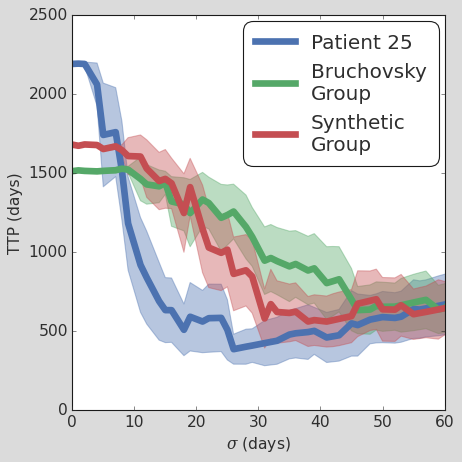

In [74]:
# Plot variation in ttp
fix, ax = plt.subplots(1,1,figsize=(6,6))

for m, (model_name, n_epochs) in enumerate(models.items()):
    ax.plot(sigma_vals, s_means[m], linestyle = '-', linewidth='6', color=group_cols[m], label=labels[m])
    ax.fill_between(sigma_vals, s_lower[m], s_upper[m], color=group_cols[m], alpha=0.4)
    # ax.set_ylim(bottom=0); ax.set_xlim(0, max(sigma_vals));

plt.legend(loc=1, fontsize=18, numpoints=1, markerscale=2).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel(r'$\sigma$ (days)'); plt.ylabel('TTP (days)'); plt.xlim(0, 60)
plt.tight_layout(); plt.savefig("figures/fig_sigma_sensitivity.png")

In [62]:
loss = 0.2

for m, (model_name, n_epochs) in enumerate(models.items()):
    idx = next((i for i, x in enumerate(s_means[m]) if x < s_means[m][0] * (1-loss)), None)
    print(f"{print_labels[m]} has {int(loss*100)}% loss of performance when \sigma = {sigma_vals[idx]} days")

Patient 25 has 20% loss of performance when \sigma = 5 days
Bruchovsky Group has 20% loss of performance when \sigma = 28 days
Synthetic Group has 20% loss of performance when \sigma = 18 days
